### MFIN7034 Problem Set 2 – Factor and Portfolio Analysis

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
port_ret_df = pd.read_csv('data\portfolio_return_series.csv');
port_ret_df['YearMonth'] = pd.to_datetime(port_ret_df['YearMonth'])
port_ret_df.set_index('YearMonth', inplace=True)
port_ret_df = port_ret_df.apply(lambda x: x / 100)
port_ret_df.columns = port_ret_df.columns.str.strip()

In [3]:
port_ret_df.head()

,Small-cap growth,Small-cap value,Large-cap growth,Large-cap value,MKT
YearMonth,,,,,
1982-01-01,-0.0487,-0.0084,-0.0189,0.0043,-0.0004
1982-02-01,-0.0747,-0.0074,-0.0741,-0.0195,0.0018
1982-03-01,-0.0219,0.0149,-0.0196,0.0193,0.0247
1982-04-01,0.0653,0.0413,0.0573,0.0258,0.0526
1982-05-01,-0.0357,-0.0096,-0.0347,-0.0245,0.0010


#### 1.1 Certainty Equivalent Rate of Return

The value of ( A ) can be calculated using the formula:

$$
A = \frac{E(R_m) - R_f}{w \cdot \text{Var}(R_m)} 
$$

where:
- $E(R_m)$ is the expected return of the market.
- $R_f$ is the risk-free rate.
- $w$  is the weight in the market index.
- $\text{Var}(R_m)$ is the variance of the market return.

Calculated A: 5.81


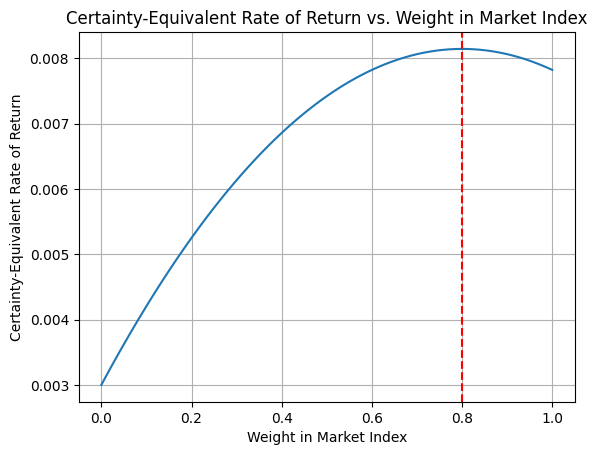

In [4]:
market_returns = port_ret_df['MKT']

# expected return and variance
E_Rm = market_returns.mean()
Var_Rm = market_returns.var()

R_f = 0.003  # Risk-free rate per month in decimal
w_optimal = 0.8  # Current allocation in the market index

A = (E_Rm - R_f) / (w_optimal * Var_Rm)
print(f"Calculated A: {A:.2f}")

# Plotting the certainty-equivalent rate of return
weights = np.linspace(0, 1, 100)
U_values = weights * E_Rm + (1 - weights) * R_f - 0.5 * A * (weights**2) * Var_Rm

plt.plot(weights, U_values)
plt.axvline(x=0.8, color='r', linestyle='--')
plt.xlabel('Weight in Market Index')
plt.ylabel('Certainty-Equivalent Rate of Return')
plt.title('Certainty-Equivalent Rate of Return vs. Weight in Market Index')
plt.grid(True)
plt.show()

#### 1.2 Efficient Frontier and Tangent Portfolio

In [5]:
import numpy as np

# generate weights ranging from -0.5 to 1.5, that sum to 1
# returns a numpy array
def generate_weights(n):
    S_x = (1 + 0.5 * n) / 2.0
    x = []
    remaining_sum = S_x
    for i in range(n):
        variables_left = n - i
        lower = max(0.0, remaining_sum - (variables_left - 1) * 1.0)
        upper = min(1.0, remaining_sum)
        xi = np.random.uniform(low=lower, high=upper)
        x.append(xi)
        remaining_sum -= xi
        
    # Convert x to weights in the range [-0.5, 1.5]
    weights = [2 * xi - 0.5 for xi in x]
    current_total = sum(weights)
    weights[-1] += (1.0 - current_total)
    if weights[-1] < -0.5 or weights[-1] > 1.5:
        discrepancy = 1.0 - sum(weights)
        adjustment = discrepancy / n
        weights = [w + adjustment for w in weights]

    return np.array(weights)

In [6]:
# Function to simulate portfolios
def simulate_portfolios(returns, R_f=0.003, num_portfolios=10000, constraints=None):
    num_assets = returns.shape[1]
    results = np.zeros((3, num_portfolios))
    weights_record = []

    for i in tqdm(range(num_portfolios)):
        if constraints == 'long_only':
            weights = np.random.random(num_assets)
            weights /= np.sum(weights)
        elif constraints == 'bounded':
            """
            # Weight Normalization (AI agent report point): 
            # Original code normalized bounded 
            # weights without ensuring the sum is non-zero, 
            # potentially creating NaN values
            weights = np.random.uniform(-0.5, 1.5, num_assets)
            weights /= np.sum(weights)
            """
            # weights from -0.5 to 1.5
            weights = generate_weights(num_assets)

        weights_record.append(weights)
        portfolio_return = np.sum(weights * returns.mean())
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = (portfolio_return - R_f) / portfolio_std_dev

    return results, weights_record

# Function to plot the efficient frontier
def plot_efficient_frontier(results, weights_record, returns, R_f=0.003):
    max_sharpe_idx = np.argmax(results[2])
    max_sharpe_return = results[0, max_sharpe_idx]
    max_sharpe_std_dev = results[1, max_sharpe_idx]
    max_sharpe_weights = weights_record[max_sharpe_idx]

    # Calculate tangent line parameters
    slope = (max_sharpe_return - R_f) / max_sharpe_std_dev
    x_tangent = np.linspace(0, max_sharpe_std_dev * 1.5, 100)
    y_tangent = R_f + slope * x_tangent

    plt.figure(figsize=(10, 7))
    plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='viridis', marker='o', s=10, alpha=0.3)
    plt.colorbar(label='Sharpe Ratio')
    plt.scatter(max_sharpe_std_dev, max_sharpe_return, c='red', marker='*', s=500, label='Tangent Portfolio')
    plt.plot(x_tangent, y_tangent, '--', c='orange', label='Capital Market Line')
    # Set dynamic axis limits with 10% padding
    x_padding = 0.1 * np.max(results[1,:])
    y_padding = 0.1 * np.max(results[0,:])
    plt.xlim(max(0, np.min(results[1,:]) - x_padding), 
             np.max(results[1,:]) + x_padding)
    plt.ylim(np.min(results[0,:]) - y_padding, 
             np.max(results[0,:]) + y_padding)
    plt.title(f'Efficient Frontier for Scenario')
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Return')
    plt.legend(labelspacing=0.8)
    plt.show()

    print(f'Tangent Portfolio Weights:')
    for i, col in enumerate(returns.columns):
        print(f"{col}: {max_sharpe_weights[i]:.2f}")

    print(f'Sharpe Ratio: {slope:.2f}')
    certainty_equivalent_return = max_sharpe_return - 0.5 * A * (max_sharpe_std_dev ** 2)
    print(f'Certainty Equivalent Rate of Return: {certainty_equivalent_return:.4f}')

100%|██████████| 10000/10000 [00:02<00:00, 3476.39it/s]


==================== Scenarios 1====================


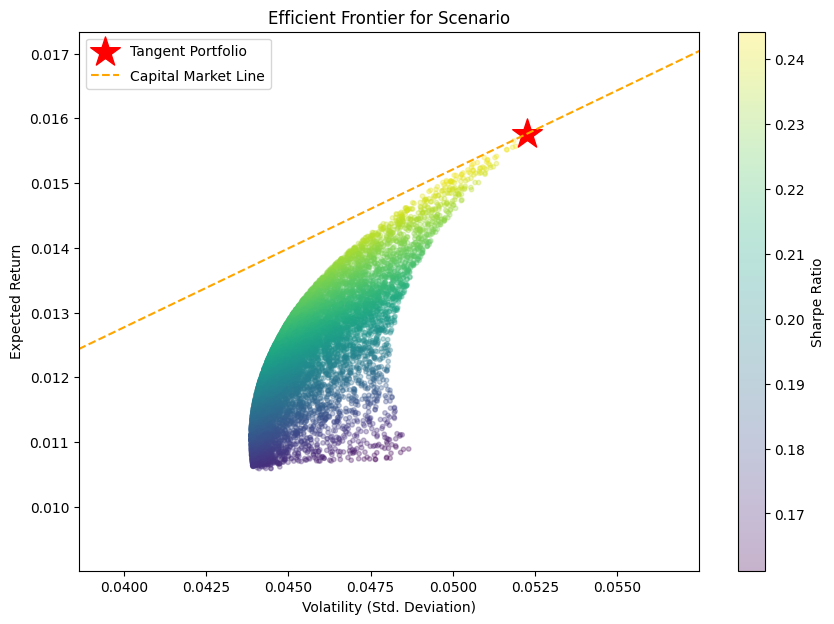

Tangent Portfolio Weights:
MKT: 0.98
Large-cap growth: 0.01
Large-cap value: 0.00
Sharpe Ratio: 0.24
Certainty Equivalent Rate of Return: 0.0078




100%|██████████| 10000/10000 [00:03<00:00, 3307.30it/s]


==================== Scenarios 2====================


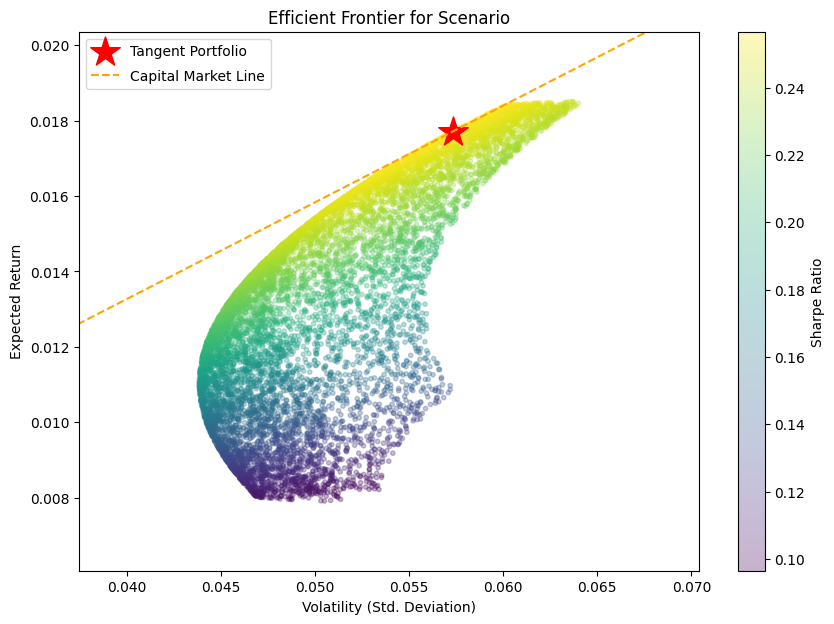

Tangent Portfolio Weights:
MKT: 1.37
Large-cap growth: 0.13
Large-cap value: -0.50
Sharpe Ratio: 0.26
Certainty Equivalent Rate of Return: 0.0082




100%|██████████| 100000/100000 [00:30<00:00, 3319.82it/s]


==================== Scenarios 3====================


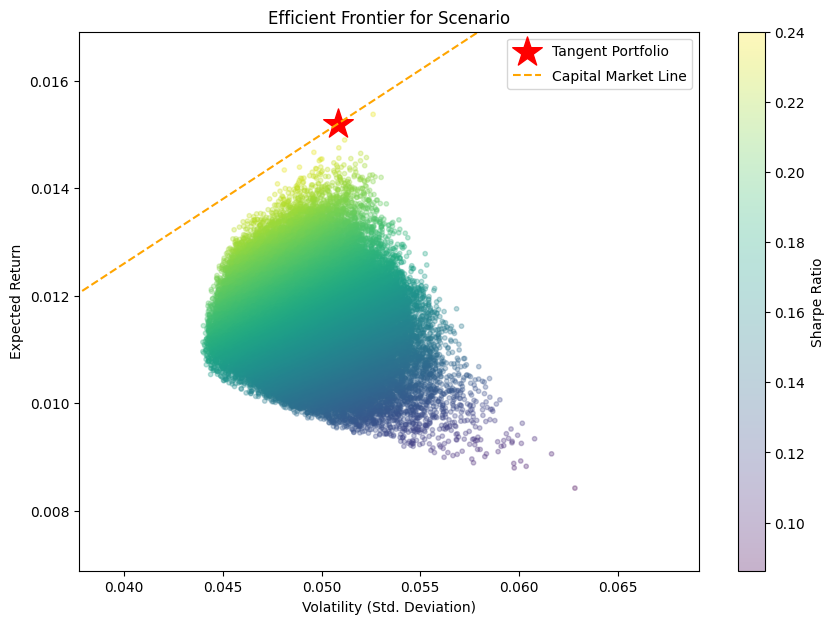

Tangent Portfolio Weights:
MKT: 0.87
Large-cap growth: 0.08
Large-cap value: 0.03
Small-cap growth: 0.01
Small-cap value: 0.01
Sharpe Ratio: 0.24
Certainty Equivalent Rate of Return: 0.0077




100%|██████████| 100000/100000 [00:30<00:00, 3292.82it/s]


==================== Scenarios 4====================


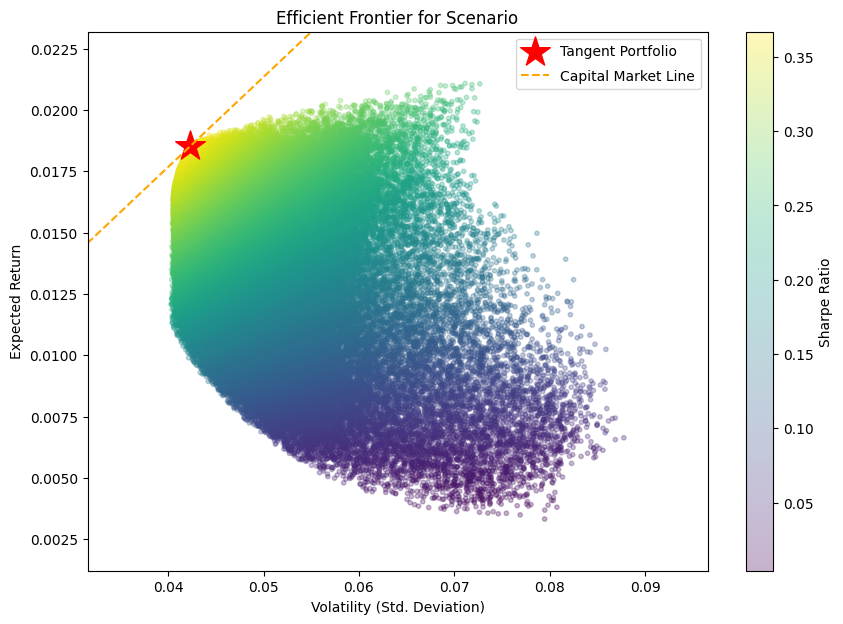

Tangent Portfolio Weights:
MKT: 1.49
Large-cap growth: 0.79
Large-cap value: -0.28
Small-cap growth: -0.50
Small-cap value: -0.50
Sharpe Ratio: 0.37
Certainty Equivalent Rate of Return: 0.0133




In [7]:
scenarios = [
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value']),
    ('long_only', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value']),
    ('bounded', ['MKT', 'Large-cap growth', 'Large-cap value', 'Small-cap growth', 'Small-cap value'])
]

for i, (constraint, assets) in enumerate(scenarios, 1):
    selected_returns = port_ret_df[assets]
    num_simulation = 10000
    # because more assets, need to run more simulation
    if i >= 3:
        num_simulation *= 10
    results, weights_record = simulate_portfolios(selected_returns, num_portfolios=num_simulation, constraints=constraint)
    print('='*20 + ' Scenarios ' + str(i) + '='*20)
    plot_efficient_frontier(results, weights_record, selected_returns)
    print('\n')

#### 2.1 Factor Zoo Deeper Explorations - Trials

In [8]:
fund_full_df = pd.read_csv('data/fundamental_quarterly.csv')
fund_full_df.head()

C:\Users\Betty\AppData\Local\Temp\ipykernel_30376\3290292102.py:1: DtypeWarning: Columns (2,17,19,20,24,25,27,32,33,37,39,40,41,42,654,655,656,657,661,663,671,675,676,681,682,686) have mixed types. Specify dtype option on import or set low_memory=False.
  fund_full_df = pd.read_csv('data/fundamental_quarterly.csv')


,GVKEY,LINKPRIM,LIID,LINKTYPE,LPERMNO,LPERMCO,LINKDT,LINKENDDT,datadate,fyearq,...,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,dldte,ipodate
0,1004,P,1,LU,54594,20000,1972-04-24,E,1998-08-31,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
1,1004,P,1,LU,54594,20000,1972-04-24,E,1998-11-30,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
2,1004,P,1,LU,54594,20000,1972-04-24,E,1999-02-28,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
3,1004,P,1,LU,54594,20000,1972-04-24,E,1999-05-31,1998,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24
4,1004,P,1,LU,54594,20000,1972-04-24,E,1999-08-31,1999,...,1,5080,110.0,925.0,B,IL,0.0,www.aarcorp.com,NaN,1972-04-24


In [17]:
factor_lst = [
    'chq', 
    'dd1q', 
    'dlttq', 
    'drcq', 
    'dvintfq', 
    'epsfi12', 
    'esubq', 
    'lctq', 
    'lltq', 
    'oiadpq', 
    'capxy',
    'actq',
    'capr3q',
    'cheq',
    'ceqq',
    'derlcq',
    'derlltq',
    'dlcq',
    'finrevq',
    'finnpq',
    'finreccq',
    'invtq',
    'ivaeqq',
    'niq',
    'npq',
    'niitq',
    'nopiq',
    'oeps12',
    'oepsxq',
    'opepsq',
    'piq',
    'revtq',
    'saleq',
    'tieq',
    'tiiq',
    'tstkq',
    'uinvq',
    'wcapq',
    'amcy',
    'dvy',
    'glcedy',
    'prccq'
]
fund_df = fund_full_df[['LPERMNO', 'datadate'] + factor_lst]
fund_df['datadate'] = pd.to_datetime(fund_df['datadate'])
fund_df.drop_duplicates(subset=['LPERMNO', 'datadate'], inplace=True)

C:\Users\Betty\AppData\Local\Temp\ipykernel_30376\2935322329.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_df['datadate'] = pd.to_datetime(fund_df['datadate'])
C:\Users\Betty\AppData\Local\Temp\ipykernel_30376\2935322329.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_df.drop_duplicates(subset=['LPERMNO', 'datadate'], inplace=True)


In [19]:
stock_ret_df = pd.read_csv('data/monthly_stock_returns.csv')
stock_ret_df['Month'] = pd.to_datetime(stock_ret_df['YYYYMM'], format='%Y%m')
stock_ret_df.drop(columns=['YYYYMM'], inplace=True)
stock_ret_df.apply(pd.to_numeric, errors='coerce').astype(float)
stock_ret_df.head()

,PERMNO,MthPrc,MthRet,Month
0,10324,52.0000,0.155556,2000-01-01
1,10324,57.4375,0.104567,2000-02-01
2,10324,50.1250,-0.127312,2000-03-01
3,10324,48.8125,-0.026185,2000-04-01
4,10324,56.8125,0.163892,2000-05-01


In [ ]:
# need to shift 1 month down, because 2000-03-31 should be resampled to 2000-04 not 03
# need to shift 1 additional month, because to match the return: 2000-04-01 given the factor info, trade, return on 2000-05-01
fund_df['YearMonth'] = (fund_df['datadate'] + pd.DateOffset(months=2)).dt.to_period('M')
fund_df['YearMonth'] = fund_df['YearMonth'].dt.to_timestamp(how='start')
fund_df.head()

C:\Users\Betty\AppData\Local\Temp\ipykernel_30376\860311819.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_df['YearMonth'] = (fund_df['datadate'] + pd.DateOffset(months=2)).dt.to_period('M')
C:\Users\Betty\AppData\Local\Temp\ipykernel_30376\860311819.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fund_df['YearMonth'] = fund_df['YearMonth'].dt.to_timestamp(how='start')


,LPERMNO,datadate,chq,dd1q,dlttq,drcq,dvintfq,epsfi12,esubq,lctq,...,tieq,tiiq,tstkq,uinvq,wcapq,amcy,dvy,glcedy,prccq,YearMonth
0,54594,1998-08-31,NaN,NaN,177.450,NaN,NaN,NaN,NaN,180.615,...,NaN,NaN,16.577,NaN,329.193,NaN,2.355,NaN,22.125,1998-10-01
1,54594,1998-11-30,NaN,NaN,178.927,NaN,NaN,1.40,NaN,200.186,...,NaN,NaN,20.425,NaN,347.314,NaN,4.697,NaN,25.250,1999-01-01
2,54594,1999-02-28,NaN,NaN,181.018,NaN,NaN,1.44,NaN,159.874,...,NaN,NaN,24.219,NaN,338.249,NaN,7.048,NaN,15.125,1999-04-01
3,54594,1999-05-31,NaN,NaN,180.939,NaN,NaN,1.49,NaN,173.586,...,NaN,NaN,25.463,NaN,334.600,NaN,9.375,NaN,19.750,1999-07-01
4,54594,1999-08-31,NaN,NaN,180.800,NaN,NaN,1.54,NaN,156.581,...,NaN,NaN,25.574,NaN,341.071,NaN,2.329,NaN,21.375,1999-10-01


In [63]:
def reconstruct_monthly_data(df):
    
    # Group by PERMNO and process each group
    monthly_dfs = []
    for permno, group in tqdm(df.groupby('LPERMNO')):
        group = group.set_index('YearMonth').sort_index()

        # Create a monthly date range
        start_date = group.index.min()
        end_date = group.index.max()
        monthly_dates = pd.date_range(start=start_date, end=end_date, freq='MS')

        # Reindex to the monthly dates and forward-fill the data
        group_monthly = group.reindex(monthly_dates).ffill().reset_index()
        group_monthly = group_monthly.rename(columns={'index': 'YearMonth'})
        group_monthly['LPERMNO'] = permno
        monthly_dfs.append(group_monthly)
    
    # Concatenate all groups and clean up
    monthly_df = pd.concat(monthly_dfs, ignore_index=True)
    
    # Reorder columns to match the original structure (adjust as needed)
    original_columns = df.columns.tolist()
    monthly_df = monthly_df[original_columns]
    
    return monthly_df

fund_monthly_df = reconstruct_monthly_data(fund_df)
fund_monthly_df.head()

100%|██████████| 18032/18032 [00:29<00:00, 619.89it/s]


,LPERMNO,datadate,chq,dd1q,dlttq,drcq,dvintfq,epsfi12,esubq,lctq,...,tieq,tiiq,tstkq,uinvq,wcapq,amcy,dvy,glcedy,prccq,YearMonth
0,10001,1998-06-30,0.058,NaN,17.278,NaN,NaN,0.64,0.0,6.745,...,NaN,NaN,0.0,5.226,5.581,NaN,NaN,NaN,8.625,1998-08-01
1,10001,1998-06-30,0.058,NaN,17.278,NaN,NaN,0.64,0.0,6.745,...,NaN,NaN,0.0,5.226,5.581,NaN,NaN,NaN,8.625,1998-09-01
2,10001,1998-06-30,0.058,NaN,17.278,NaN,NaN,0.64,0.0,6.745,...,NaN,NaN,0.0,5.226,5.581,NaN,NaN,NaN,8.625,1998-10-01
3,10001,1998-09-30,0.085,NaN,17.016,NaN,NaN,0.63,0.0,10.774,...,NaN,NaN,0.0,5.218,4.113,NaN,NaN,NaN,9.250,1998-11-01
4,10001,1998-09-30,0.085,NaN,17.016,NaN,NaN,0.63,0.0,10.774,...,NaN,NaN,0.0,5.218,4.113,NaN,NaN,NaN,9.250,1998-12-01


In [64]:
merged_df = pd.merge(stock_ret_df, fund_monthly_df, left_on=['PERMNO', 'Month'], right_on=['LPERMNO', 'YearMonth'], how='inner')
merged_df.drop(columns=['LPERMNO', 'Month', 'datadate'], inplace=True)
merged_df.head()

,PERMNO,MthPrc,MthRet,chq,dd1q,dlttq,drcq,dvintfq,epsfi12,esubq,...,tieq,tiiq,tstkq,uinvq,wcapq,amcy,dvy,glcedy,prccq,YearMonth
0,10324,52.0000,0.155556,NaN,NaN,272.399,NaN,NaN,1.58,NaN,...,NaN,NaN,0.901,NaN,514.399,NaN,0.0,NaN,45.0625,2000-01-01
1,10324,57.4375,0.104567,NaN,NaN,272.622,NaN,NaN,1.71,NaN,...,NaN,NaN,0.901,NaN,487.561,NaN,0.0,NaN,45.0000,2000-02-01
2,10324,50.1250,-0.127312,NaN,NaN,272.622,NaN,NaN,1.71,NaN,...,NaN,NaN,0.901,NaN,487.561,NaN,0.0,NaN,45.0000,2000-03-01
3,10324,48.8125,-0.026185,NaN,NaN,272.622,NaN,NaN,1.71,NaN,...,NaN,NaN,0.901,NaN,487.561,NaN,0.0,NaN,45.0000,2000-04-01
4,10324,56.8125,0.163892,NaN,NaN,272.988,NaN,NaN,1.91,NaN,...,NaN,NaN,0.901,NaN,432.740,NaN,0.0,NaN,50.1250,2000-05-01


In [65]:
def calculate_factor_returns(data, factor):
    factor_returns = []
    # Group by month
    for month, group in data.groupby('YearMonth'):
        # Sort by the selected factor
        sorted_group = group.sort_values(by=factor, ascending=True)
        
        # Calculate top 20% and bottom 20%
        top_20 = sorted_group.head(int(len(sorted_group) * 0.2))
        bottom_20 = sorted_group.tail(int(len(sorted_group) * 0.2))

        # Calculate average returns
        top_20_return = top_20['MthRet'].mean()
        bottom_20_return = bottom_20['MthRet'].mean()
        
        # Calculate factor return
        factor_return = top_20_return - bottom_20_return
        factor_returns.append((month, factor_return))
    
    result_df = pd.DataFrame(factor_returns, columns=['Date', f'{factor}_Return'])
    return result_df

100%|██████████| 42/42 [00:03<00:00, 11.21it/s]


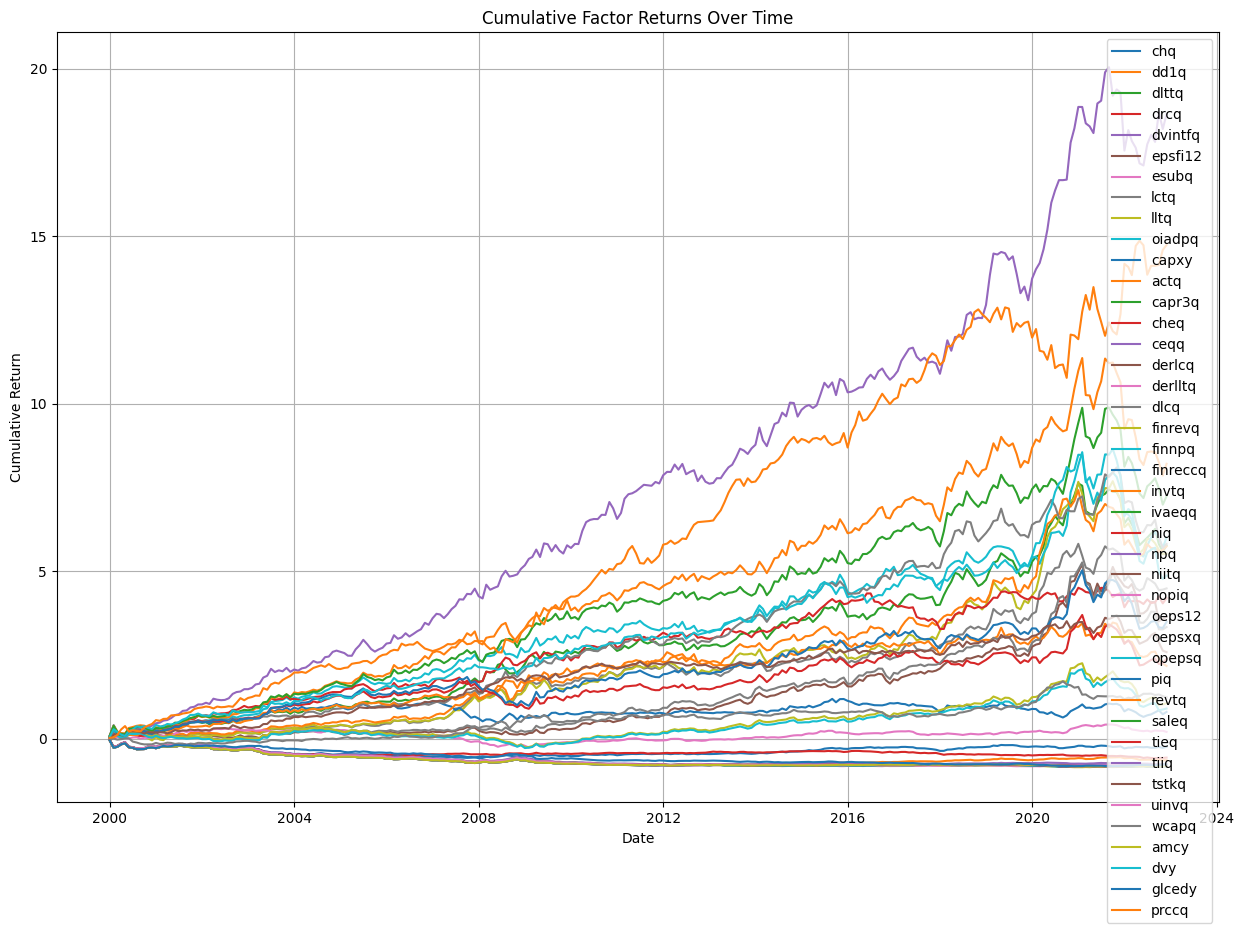

In [66]:
plt.figure(figsize=(15, 10))

for factor in tqdm(factor_lst):
    factor_return_df = calculate_factor_returns(merged_df, factor)
    factor_return_df['Cumulative_Return'] = (1 + factor_return_df[f'{factor}_Return']).cumprod() - 1
    plt.plot(factor_return_df['Date'], factor_return_df['Cumulative_Return'], label=f'{factor}')

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Factor Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()

100%|██████████| 5/5 [00:00<00:00, 10.90it/s]


============================== Top 5 Factors ==============================


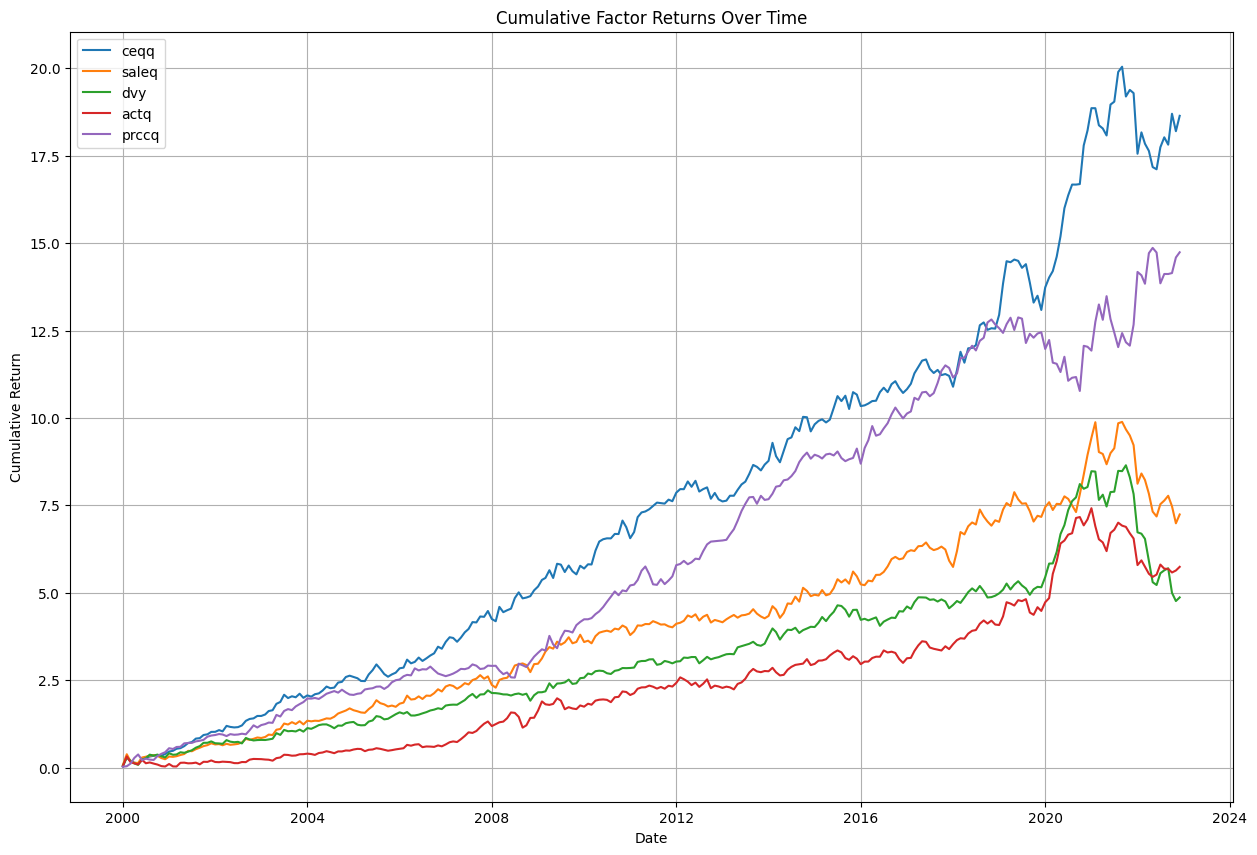

In [69]:
top_factor_lst = [
    'ceqq',
    'saleq',
    'dvy',
    'actq',
    'prccq',
]

plt.figure(figsize=(15, 10))

for factor in tqdm(top_factor_lst):
    factor_return_df = calculate_factor_returns(merged_df, factor)
    factor_return_df['Cumulative_Return'] = (1 + factor_return_df[f'{factor}_Return']).cumprod() - 1
    plt.plot(factor_return_df['Date'], factor_return_df['Cumulative_Return'], label=f'{factor}')

print('='*30 + ' Top 5 Factors ' + '='*30)

plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Factor Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()